Columns: ['Unnamed: 0', 'date', 'text', 'is_pinned', 'attachments', 'post_source', 'comments', 'likes', 'reposts', 'views', 'len_text', 'post_source_id', 'year', 'month', 'dayofweek', 'hour', 'text_len']


,Unnamed: 0,date,text,is_pinned,attachments,post_source,comments,likes,reposts,views,len_text,post_source_id,year,month,dayofweek,hour,text_len
0,0,2021-11-01 10:32:31,"Нет, это не шутка! Попробовать 34 курса и инте...",1.0,10.0,vk,152,417,719,63145,406,1,2021,11,0,10,406
1,1,2022-01-02 10:18:21,"Интересно, что случилось с теми зайчиками и ли...",0.0,6.0,api,2,26,5,17319,427,0,2022,1,6,10,427
2,2,2021-12-31 10:00:22,"Уверены, по дороге к нашему аккаунту вы успели...",0.0,5.0,api,3,87,57,21783,237,0,2021,12,4,10,237
3,3,2021-12-29 07:00:40,"Пост-напоминалка для всех, кто забыл поздравит...",0.0,8.0,api,4,103,66,24419,402,0,2021,12,2,7,402
4,4,2021-12-28 14:16:42,Периодически слышите фразу: «Мы вам перезвоним...,0.0,6.0,api,0,28,5,19849,572,0,2021,12,1,14,572


Saved vitrina: data/vitrinas/daily_metrics.csv


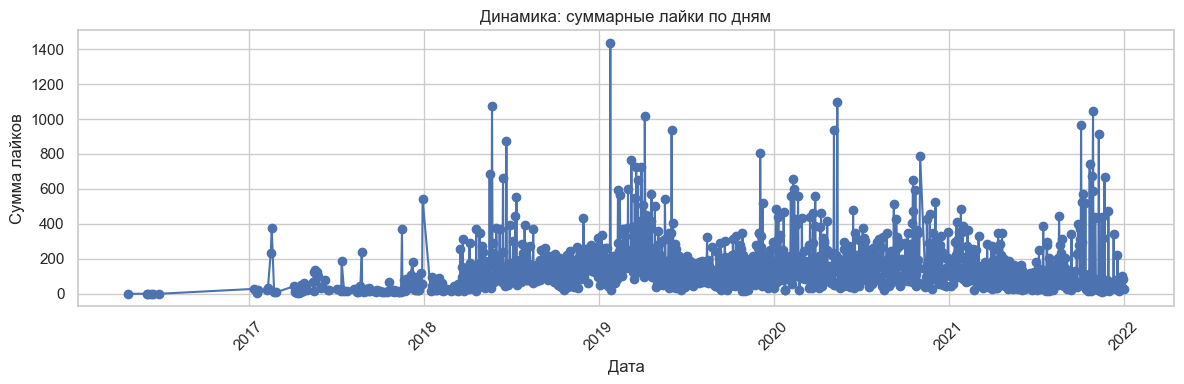

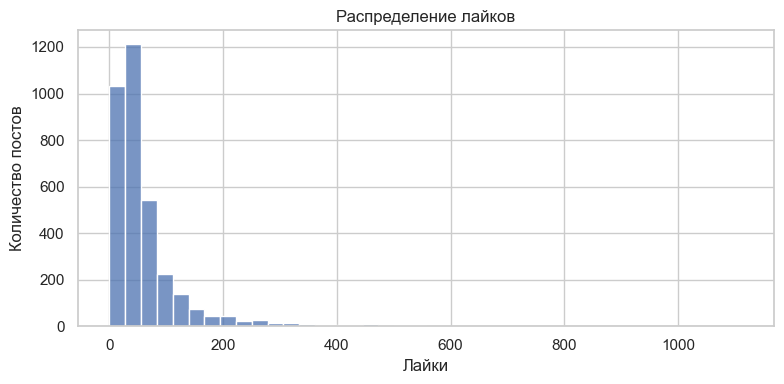

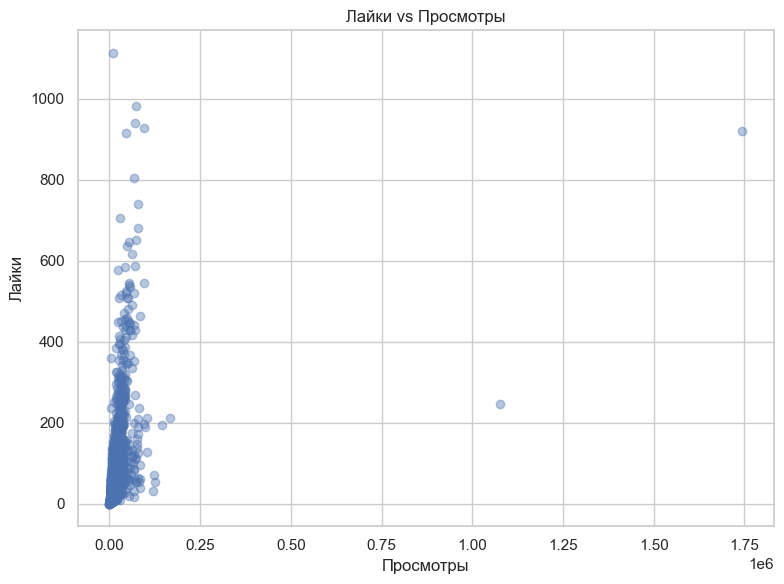

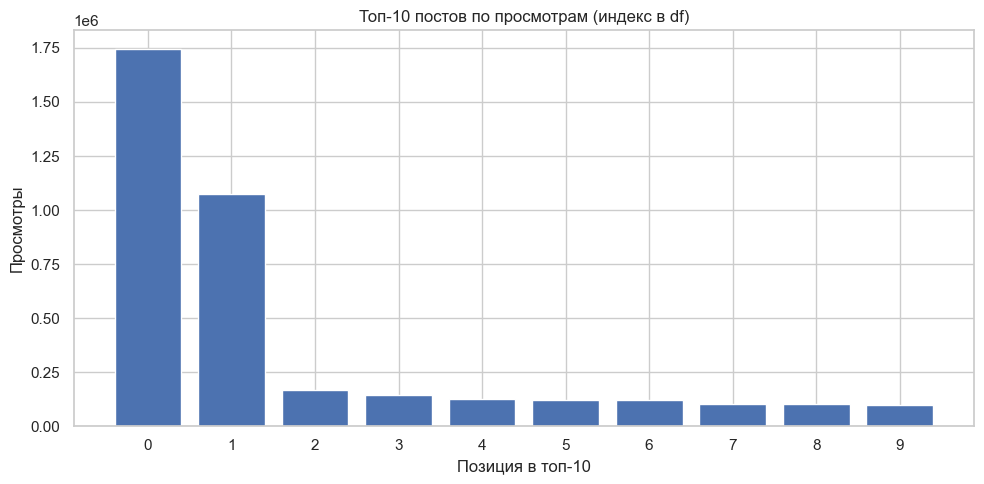

,views,likes,comments,text_len
0,1744092,919,7,310
1,1075555,246,4,480
2,165797,211,48,79
3,145408,194,7,376
4,125253,53,2,343
5,122821,70,34,607
6,120200,32,16,723
7,103909,211,5,497
8,103551,128,6,590
9,97191,189,4,246


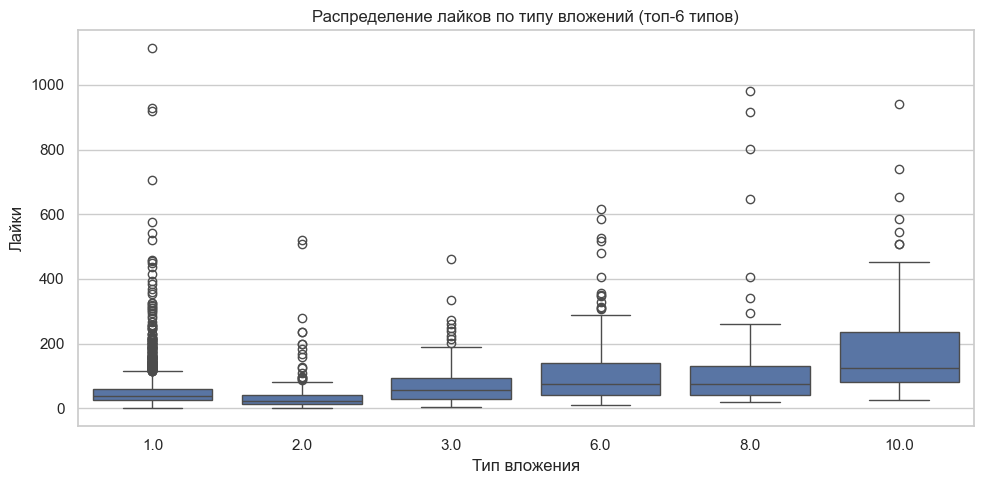


Графики сохранены в папке figures/, витрины в data/vitrinas/.


In [1]:

# Dashboards / Vitrinas script

import os
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

sns.set(style="whitegrid")
plt.rcParams.update({'figure.max_open_warning': 0})

# Папки для результатов
os.makedirs("figures", exist_ok=True)
os.makedirs("data/vitrinas", exist_ok=True)

# Подключаемся к базе и загружаем таблицу
DB_PATH = "vk_cleaned.db"
TABLE = "vk_posts"

conn = sqlite3.connect(DB_PATH)
df = pd.read_sql(f"SELECT * FROM {TABLE}", conn)
conn.close()

# Покажем колонки и первые строки (быстрая проверка)
print("Columns:", df.columns.tolist())
display(df.head())

# Приводим дату к datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')


In [ ]:
# --- Базовые агрегаты / витрины ---
total_posts = len(df)
min_date = df['date'].min()
max_date = df['date'].max()
avg_likes = df['likes'].mean() if 'likes' in df.columns else None
median_likes = df['likes'].median() if 'likes' in df.columns else None
avg_views = df['views'].mean() if 'views' in df.columns else None

# Доля постов без текста (text_len==0) — если есть text_len
no_text_pct = None
if 'text_len' in df.columns:
    no_text_pct = (df['text_len'] == 0).mean()

# Покажем набор основных метрик красиво
metrics_html = f"""
<h3>Ключевые метрики</h3>
<ul>
  <li>Total posts: <b>{total_posts}</b></li>
  <li>Date range: <b>{min_date.date() if pd.notna(min_date) else 'N/A'}</b> — <b>{max_date.date() if pd.notna(max_date) else 'N/A'}</b></li>
  <li>Average likes: <b>{avg_likes:.2f}</b></li>
  <li>Median likes: <b>{median_likes:.0f}</b></li>
  <li>Average views: <b>{avg_views:.2f}</b></li>
  <li>Share of empty text posts: <b>{no_text_pct:.2%}</b></li>
</ul>
"""
display(HTML(metrics_html))

In [ ]:
# --- Витрина: дневные агрегаты (posts, likes, views) ---
daily = df.groupby(df['date'].dt.date).agg(
    posts=('date', 'count'),
    likes=('likes', 'sum') if 'likes' in df.columns else ('date','count'),
    views=('views', 'sum') if 'views' in df.columns else ('date','count')
).reset_index().rename(columns={'date':'day'})

# Сохраняем витрину
daily.to_csv("data/vitrinas/daily_metrics.csv", index=False)
print("Saved vitrina: data/vitrinas/daily_metrics.csv")

In [ ]:
# --- ГРАФИК 1: Динамика лайков по дням ---
if 'likes' in df.columns:
    plt.figure(figsize=(12,4))
    plt.plot(daily['day'], daily['likes'], marker='o')
    plt.title("Динамика: суммарные лайки по дням")
    plt.xlabel("Дата")
    plt.ylabel("Сумма лайков")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("figures/likes_by_day.png")
    plt.show()

In [ ]:
# --- ГРАФИК 2: Распределение лайков ---
if 'likes' in df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df['likes'], bins=40)
    plt.title("Распределение лайков")
    plt.xlabel("Лайки")
    plt.ylabel("Количество постов")
    plt.tight_layout()
    plt.savefig("figures/likes_distribution.png")
    plt.show()

In [ ]:
# --- ГРАФИК 3: Лайки vs Просмотры (scatter) ---
if 'likes' in df.columns and 'views' in df.columns:
    plt.figure(figsize=(8,6))
    plt.scatter(df['views'], df['likes'], alpha=0.4)
    plt.title("Лайки vs Просмотры")
    plt.xlabel("Просмотры")
    plt.ylabel("Лайки")
    plt.tight_layout()
    plt.savefig("figures/likes_vs_views.png")
    plt.show()

In [ ]:
# --- ГРАФИК 4: Топ-10 постов по просмотрам (bar) ---
if 'views' in df.columns:
    top_views = df.nlargest(10, 'views').reset_index(drop=True)
    plt.figure(figsize=(10,5))
    plt.bar(top_views.index.astype(str), top_views['views'])
    plt.title("Топ-10 постов по просмотрам (индекс в df)")
    plt.xlabel("Позиция в топ-10")
    plt.ylabel("Просмотры")
    plt.tight_layout()
    plt.savefig("figures/top10_by_views.png")
    plt.show()
    display(top_views[['views','likes','comments','text_len']].head(10))

In [ ]:
# --- ГРАФИК 5: boxplot лайков по типу вложений (attachments) ---
if 'attachments' in df.columns and 'likes' in df.columns:
    # возьмём топ-6 типов вложений чтобы диаграмма не была переполнена
    top_attach = df['attachments'].value_counts().index[:6].tolist()
    df_box = df[df['attachments'].isin(top_attach)]
    plt.figure(figsize=(10,5))
    sns.boxplot(x='attachments', y='likes', data=df_box)
    plt.title("Распределение лайков по типу вложений (топ-6 типов)")
    plt.xlabel("Тип вложения")
    plt.ylabel("Лайки")
    plt.tight_layout()
    plt.savefig("figures/likes_by_attachments_box.png")
    plt.show()

In [ ]:
# --- Доп. витрина: топ авторов (если есть author_id или author_name) ---
if 'author_id' in df.columns or 'author_name' in df.columns:
    author_col = 'author_id' if 'author_id' in df.columns else 'author_name'
    authors = df.groupby(author_col).agg(
        posts=('date','count'),
        total_likes=('likes','sum') if 'likes' in df.columns else ('date','count'),
        total_views=('views','sum') if 'views' in df.columns else ('date','count')
    ).reset_index().sort_values('posts', ascending=False)
    authors.head(10).to_csv("data/vitrinas/top_authors.csv", index=False)
    display(authors.head(10))
    print("Saved vitrina: data/vitrinas/top_authors.csv")

# --- Финал ---
print("\nГрафики сохранены в папке figures/, витрины в data/vitrinas/.")